# NOTEBOOK ON MODEL UNCERTAINTY IN LINEAR GAUSSIAN STATE SPECE MODELS

by Sebastian T. Glavind, February 2022

In [1]:
import numpy as np
import scipy
import scipy.stats as ss
from scipy.optimize import minimize 
from scipy.integrate import odeint
import sympy
import joblib
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
%matplotlib inline

# Import my kalman filter toolbox
# (https://github.com/SebastianGlavind/Probabilistic_modeling_and_analysis/blob/main/State-space-models/DLMtools.py)
import DLMtools as dlmt

In [2]:
print(np.__version__,', ', scipy.__version__)

1.21.2 ,  1.7.3


# Introduction

This notebook solves Example 2 from my tutorial [Linear Gaussian state space models and Kalman filters](https://nbviewer.jupyter.org/github/SebastianGlavind/Probabilistic_modeling_and_analysis/blob/main/State-space-models/SSMs_linearGaussian_Ex_MassSpringSys.ipynb) while accounting for model uncertainty.

# Properties of the data and the system

In [3]:
# https://www.halvorsen.blog/documents/programming/python/resources/powerpoints/Mass-Spring-Damper%20System%20with%20Python.pdf
# Initialization
tstart = 0
tstop = 60
dt = 0.025
# dt = 0.05
# Initial condition
x_init = [0.,0.]
time = np.arange(tstart, tstop, dt)

In [4]:
from filterpy.common import Q_continuous_white_noise
from filterpy.common import Q_discrete_white_noise

# System:
# https://stackoverflow.com/questions/47210512/using-pykalman-on-raw-acceleration-data-to-calculate-position
Phi = np.array([ [1, dt, 0.5*dt**2], [0, 1, dt], [0, 0, 1] ])
A = np.array([[ 0, 0, 1 ]])
Qbase_a = Q_continuous_white_noise(dim=3, dt=dt, spectral_density = 1) # Labbe (2020), sec. 7.3.1 (spectral density is a fitting constant)
Qbase_b = Q_discrete_white_noise(dim=3, dt=dt, var = 1) # Labbe (2020), sec. 7.3.2 (variance is a fitting constant)
Qbase_c = np.diag([0., 0., 1.]) # Labbe (2020), sec. 7.3.4 (variance is a fitting constant)

# Example 2: Variable forcing

## Using discrete (deterministic) simulations to solve the ODE system

In [5]:
# https://www.halvorsen.blog/documents/programming/python/resources/powerpoints/Mass-Spring-Damper%20System%20with%20Python.pdf
def myDiscSpringSim2(x_init, dt, N, F, c = 4, k = 2, m = 20):

    xl = []; xl.append(np.array(x_init).reshape(-1,1)) # Initial Position
    A = np.array( [ [1, dt], [-(dt*k)/m, 1 - (dt*c)/m] ] )  
    B = np.array( [ [0], [dt/m] ] )

    # Simulation
    for s in range(N):
        xl.append( A @ xl[s] + B * F[s] ) # x[s+1]
    xm = np.hstack(xl).T
    
    return(xm)

def myAcc2(x, F, c = 4, k = 2, m = 20):
    
    acc = (F - c*x[:,1] - k*x[:,0])/m
    
    return(acc)

def myDisVelAcc2(x_init, dt, N, F, c = 4, k = 2, m = 20):
    
    PosVel = myDiscSpringSim2(x_init=x_init, dt=dt, N=N, F=F, c=c, k=k, m=m)
    Acc = myAcc2(x=PosVel, F=F, c=c, k=k, m=m)
    xm = np.hstack([PosVel, Acc.reshape(-1,1)])

    return(xm)

# Force modeling

# AR
# def myForceSim(N,seed):
#     # AR(2)
#     np.random.seed(seed)
#     w = np.random.normal(size=N)*0.1
#     f = np.zeros(N); f[0] = w[0]
#     for t in range(3,N):
#         f[t] = 0.9*f[t-1] + 0.1*f[t-2] + w[t]
        
#     return(f)

# GP
def se_kern(x, y, sig_f, l_f): # Kernel function: Squared exponential (SE)
    sqdist = np.sum(x**2,1).reshape(-1,1) + np.sum(y**2,1) - 2*np.dot(x, y.T) # reshape(-1,1): from one-dim. to two-dim. array.
    K = sig_f**2 * np.exp( -0.5 * sqdist / (l_f**2) )
    return(K)

def myForceSim(tvec, sig_f, l_f, Nsim=1, seed=1):
    N = tvec.shape[0]
    # GP
    np.random.seed(seed)
    # Kernel function
    K = se_kern(tvec, tvec, sig_f, l_f)
    # Get cholesky decomposition (square root) of the covariance matrix
    eps=1e-8
    L = np.linalg.cholesky(K + eps*np.eye(N)) # add a litte jitter for numerical stability
    # Sample Nsim sets of standard normals for our test points, multiply them by the "square root" of the covariance matrix
    f = np.dot(L, np.random.normal(size=(N,Nsim)))

    return(f)

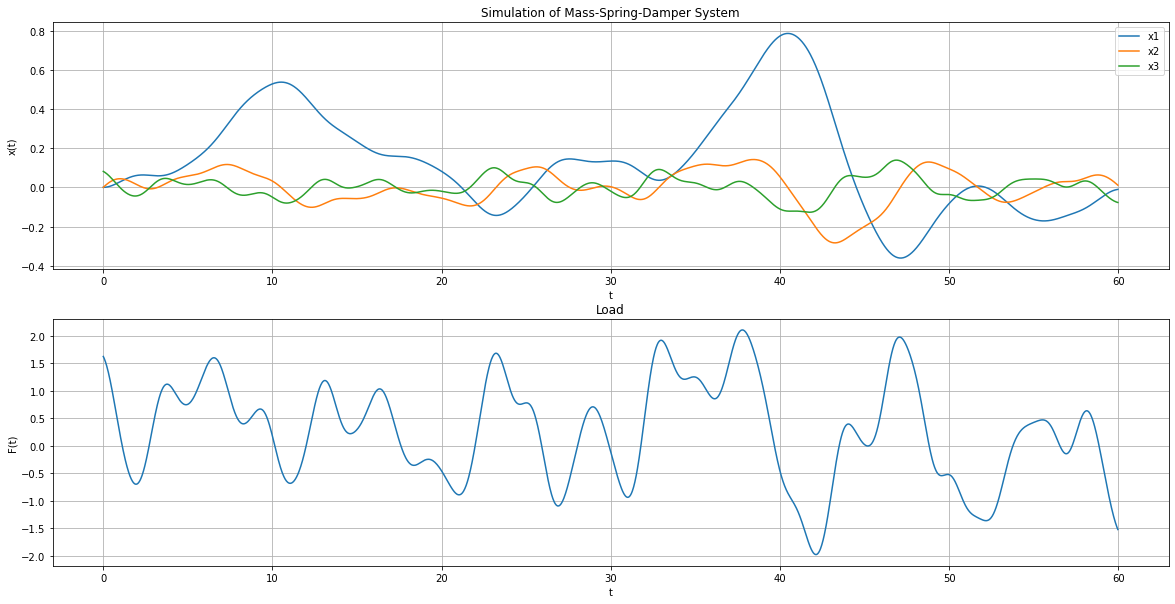

In [6]:
# Solve ODE
N = int((tstop-tstart)//dt) # Simulation length
Ft = myForceSim(tvec=time.reshape(-1,1), sig_f=1, l_f=1).flatten()
xsolve2 = myDisVelAcc2(x_init, dt, N, Ft)

# Plot the Results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10))

ax1.plot(time,xsolve2[:,0])
ax1.plot(time,xsolve2[:,1])
ax1.plot(time,xsolve2[:,2])
ax1.set_title('Simulation of Mass-Spring-Damper System')
ax1.set_xlabel('t')
ax1.set_ylabel('x(t)')
ax1.legend(["x1", "x2", "x3"])
ax1.grid()

ax2.plot(time,Ft)
ax2.set_title('Load')
ax2.set_xlabel('t')
ax2.set_ylabel('F(t)')
ax2.grid()

plt.show()

## Noisy observations from accelerometers

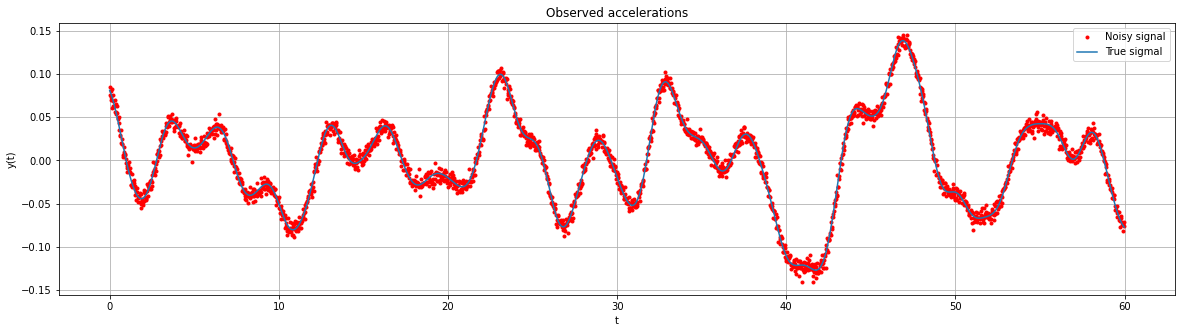

In [7]:
np.random.seed(123)
sig_noise2 = np.std(xsolve2[:,2])*0.1
var_noise2 = sig_noise2**2
y2 = xsolve2[:,2] + np.random.normal(size=(N+1)) * sig_noise2

# np.savetxt('spring_data_v4.csv', [y2, x21, x22, x23], delimiter=',')

# Plot the Results
plt.figure(figsize=(20,5))
plt.plot(time,y2, 'r.', label='Noisy signal')
plt.plot(time, xsolve2[:,2], label='True sigmal')
plt.title('Observed accelerations')
plt.xlabel('t')
plt.ylabel('y(t)')
plt.legend()
plt.grid()
plt.show()

## Parameter learning using Bayesian inference

### Gibbs sampling using forward filtering backward sampling 

See Shumway & Stoffer (2017; ch. 6) and Petris et al (2009; ch. 4) for a reference on forward filtering, backward sampling for Bayesian inference, and Gelman et al (2013; ch. 11-12) for a general reference on the Markov chain Monte Carlo algorithms.

***
Shumway, R. H. & Stoffer, D. S. (2017). Time series analysis and its applications, Springer.

Gelman, Andrew, et al. (2013), Bayesian data analysis. CRC press.

Petris, G., Petrone, S. & Campagnoli, P. (2009). Dynamic linear models with R. Springer.
***

### Initial model

In [8]:
mu02 = np.linalg.pinv(A) @ np.array([[ y2[0] ]]) # inversion from first measurement (gives the same as above)
Sigma02 = np.eye(3) * np.array([0.25**2 , var_noise2, var_noise2]) # approx. max(pos, vel)^2 (at steady state) and acc. noise variance
cQinit =  np.diag([sig_noise2*1e-3, sig_noise2*1e-2, sig_noise2])
# cQinit = np.diag(np.array([0.00090131, 0.00092389, 0.00092494])**0.5)
_, _, xf_init, Pf_init, negLogLike_init = dlmt.myKalmanFiler0(y=y2.reshape(-1,1),
                                                              cQ=cQinit, cR=np.array([sig_noise2]).reshape(-1,1),
                                                              mu0 = mu02, Sigma0 = Sigma02,
                                                              A = A, Phi = Phi )

xf_init = np.array(xf_init); Pf_init = np.array(Pf_init)
print(negLogLike_init)

[[-10753.05301727]]


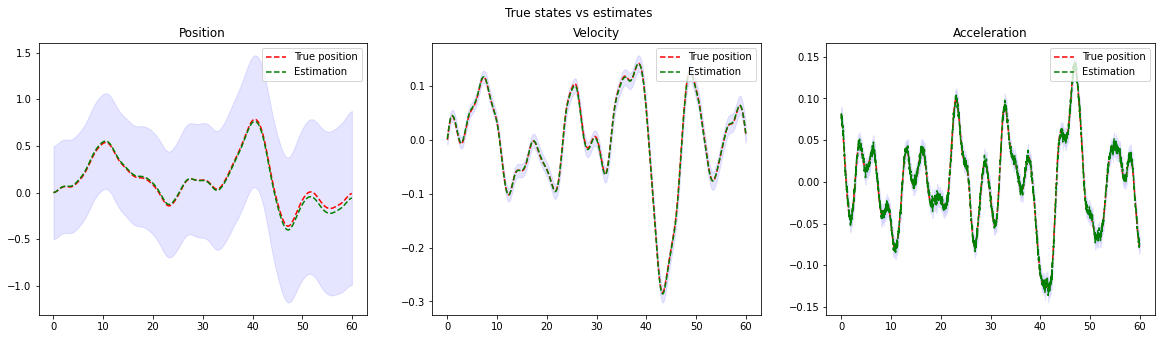

In [9]:
def plot_kf_estimation(x1,x2,x3,xf,Pf,dt):
    nt = xf.shape[0]
    xax = np.arange(0,nt,1)*dt
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
    fig.suptitle('True states vs estimates')
    
    ax1.plot(xax, x1, 'r--', label='True position')
    ax1.plot(xax, xf[:,0,0], 'g--', label='Estimation')
    ax1.fill_between(x=xax, y1=xf[:,0,0]-2*np.sqrt(Pf[:,0,0]), y2=xf[:,0,0]+2*np.sqrt(Pf[:,0,0]), alpha=0.1, color='blue');
    ax1.set_title("Position")
    ax1.legend(loc='upper right')

    ax2.plot(xax, x2, 'r--', label='True position')
    ax2.plot(xax, xf[:,1,0], 'g--', label='Estimation')
    ax2.fill_between(x=xax, y1=xf[:,1,0]-2*np.sqrt(Pf[:,1,1]), y2=xf[:,1,0]+2*np.sqrt(Pf[:,1,1]), alpha=0.1, color='blue');
    ax2.set_title("Velocity")
    ax2.legend(loc='upper right')

    ax3.plot(xax, x3, 'r--', label='True position')
    ax3.plot(xax, xf[:,2,0], 'g--', label='Estimation')
    ax3.fill_between(x=xax, y1=xf[:,2,0]-2*np.sqrt(Pf[:,2,2]), y2=xf[:,2,0]+2*np.sqrt(Pf[:,2,2]), alpha=0.1, color='blue');
    ax3.set_title("Acceleration")
    ax3.legend(loc='upper right')

    plt.show()

plot_kf_estimation(xsolve2[:,0],xsolve2[:,1],xsolve2[:,2],xf_init,Pf_init,dt)

### Forward filtering, backward sampling

In [10]:
np.random.seed(3)

collector=[]
for i in range(10):
    xb_test = dlmt.myFFBS(y=y2.reshape(-1,1), cQ=cQinit, cR=np.array([sig_noise2]).reshape(-1,1),
                          mu0 = mu02, Sigma0 = Sigma02, A = A, Phi = Phi )
    xb_test = np.array(xb_test)
    collector.append(xb_test)

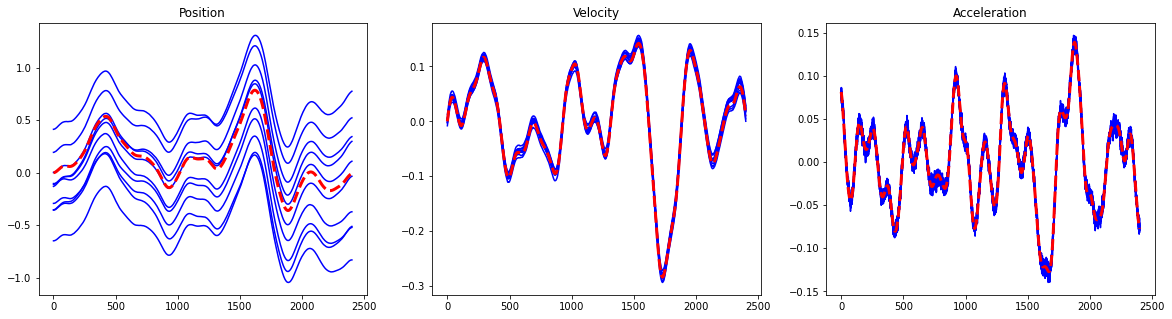

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))

for col in collector:
    ax1.plot(col[:,0,0], '-b')
    ax2.plot(col[:,1,0], '-b')
    ax3.plot(col[:,2,0], '-b')

ax1.plot(xsolve2[:,0],'--r', linewidth=3)
ax2.plot(xsolve2[:,1],'--r', linewidth=3)
ax3.plot(xsolve2[:,2],'--r', linewidth=3)

ax1.set_title('Position')
ax2.set_title('Velocity')
ax3.set_title('Acceleration')

plt.show()

### Posterior sampling under a one-parameter base Q model

In [12]:
np.random.seed(3)
xb_ffbs_base, para_ffbs_base = dlmt.myPosSamplerQbase(y=y2.reshape(-1,1), cQ=cQinit, cR=np.array([sig_noise2]).reshape(-1,1), 
                                                      mu0 = mu02, Sigma0 = Sigma02, A = A, Phi = Phi,  Qbase = Qbase_b, Nsamp=10)

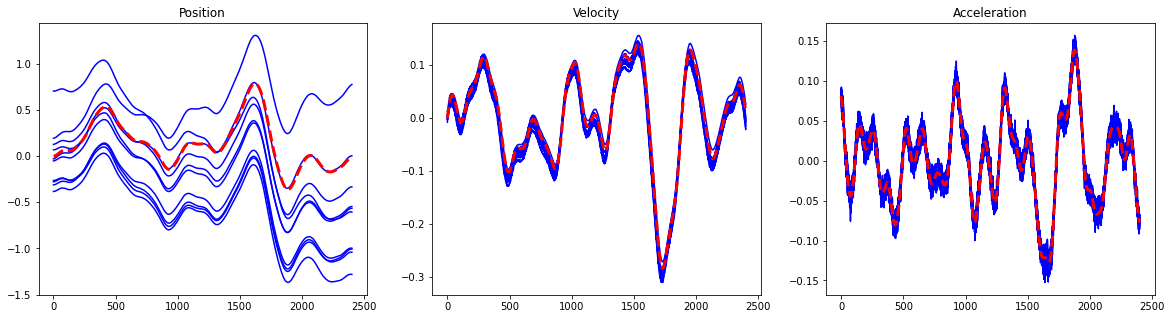

In [13]:
# plot of state space trajectories
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))

for x in xb_ffbs_base:
    ax1.plot(x[:,0,0], '-b')
    ax2.plot(x[:,1,0], '-b')
    ax3.plot(x[:,2,0], '-b')

ax1.plot(xsolve2[:,0],'--r', linewidth=3)
ax2.plot(xsolve2[:,1],'--r', linewidth=3)
ax3.plot(xsolve2[:,2],'--r', linewidth=3)

ax1.set_title('Position')
ax2.set_title('Velocity')
ax3.set_title('Acceleration')

plt.show()

For this simple covariance-model, it appears that the chain exhibits immediate steady-state behaviour.

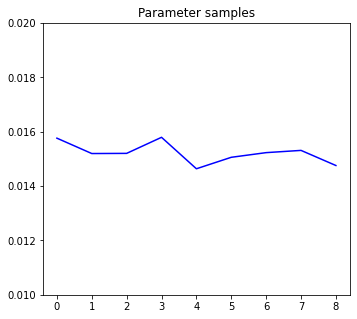

In [14]:
# plot of parameter realizations
plt.figure(figsize=(5.5,5))
plt.plot(np.array(para_ffbs_base)[1:], '-b')
plt.ylim([0.01,0.02])
plt.title('Parameter samples')
plt.show()

### Including variability in the generating mass-spring-damper system

Simulation hierarchy: $(m,k,c) \rightarrow (x_{0:T}, \theta) $

In [15]:
# Generate spring-mass systems
Nprand = 10
np.random.seed(3)
def myStateGenerator(x_init, dt, N, Ft, Nprand):
    xrandSys_list=[]
    zrandSys = np.random.normal(size=(Nprand, 3))
    murandSys = np.array([4, 2, 20])
    sigrandSys = murandSys/10
    sigrandSys[sigrandSys < 0] = 1e-8
    prandSys = zrandSys*sigrandSys + murandSys
    for i in range(Nprand):
        xrandSys_list.append( myDisVelAcc2(x_init, dt, N, Ft,
                                           c = prandSys[i,0], k = prandSys[i,1], m = prandSys[i,2]) )
    
    return(xrandSys_list)

xrandSys_list = myStateGenerator(x_init, dt, N, Ft, Nprand)
xrandSys_mat = np.array(xrandSys_list)

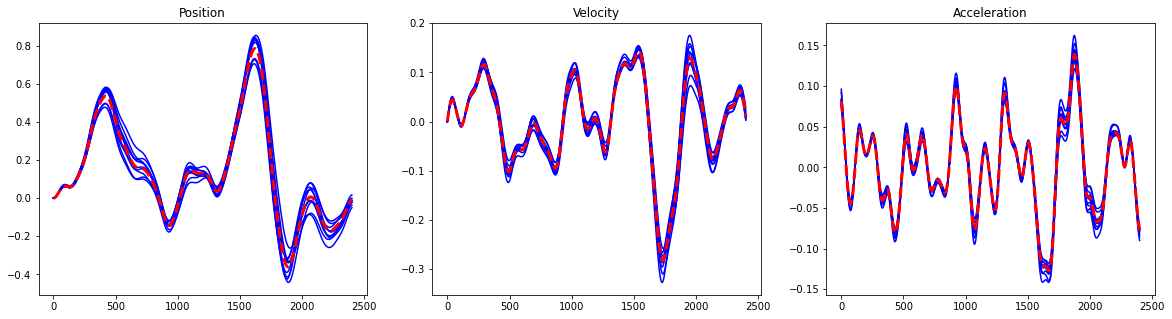

In [16]:
# plot of state space trajectories
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))

for x in xrandSys_list:
    ax1.plot(x[:,0], '-b')
    ax2.plot(x[:,1], '-b')
    ax3.plot(x[:,2], '-b')

ax1.plot(xsolve2[:,0],'--r', linewidth=3)
ax2.plot(xsolve2[:,1],'--r', linewidth=3)
ax3.plot(xsolve2[:,2],'--r', linewidth=3)

ax1.set_title('Position')
ax2.set_title('Velocity')
ax3.set_title('Acceleration')

plt.show()

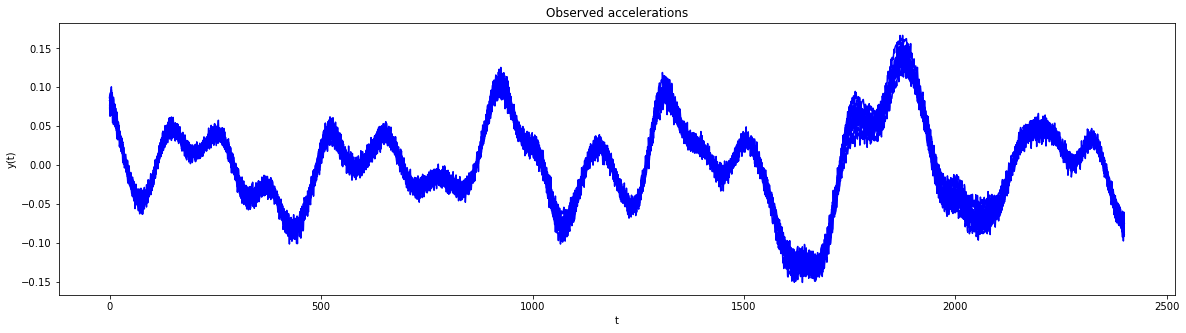

In [17]:
# realized accelerations signals (incl. noise)
np.random.seed(5)
y2rand = xrandSys_mat[:,:,2] + np.random.normal(size=(Nprand,N+1)) * sig_noise2

plt.figure(figsize=(20,5))
for i in range(y2rand.shape[0]):
    plt.plot(y2rand[i,:], '-b')
    
plt.title('Observed accelerations')
plt.xlabel('t')
plt.ylabel('y(t)')
plt.show()

In [18]:
np.random.seed(7)
Nmcmc = 20
xb_ffbs_rand_list = []
para_ffbs_rand_list = []
for i in range(Nprand):
    xb_ffbs_base_i, para_ffbs_base_i = dlmt.myPosSamplerQbase(y=y2rand[i,:].reshape(-1,1), 
                                                              cQ=cQinit, cR=np.array([sig_noise2]).reshape(-1,1), 
                                                              mu0 = mu02, Sigma0 = Sigma02, 
                                                              A = A, Phi = Phi,  
                                                              Qbase = Qbase_b, Nsamp=Nmcmc)
    xb_ffbs_rand_list.append(xb_ffbs_base_i); para_ffbs_rand_list.append(para_ffbs_base_i)

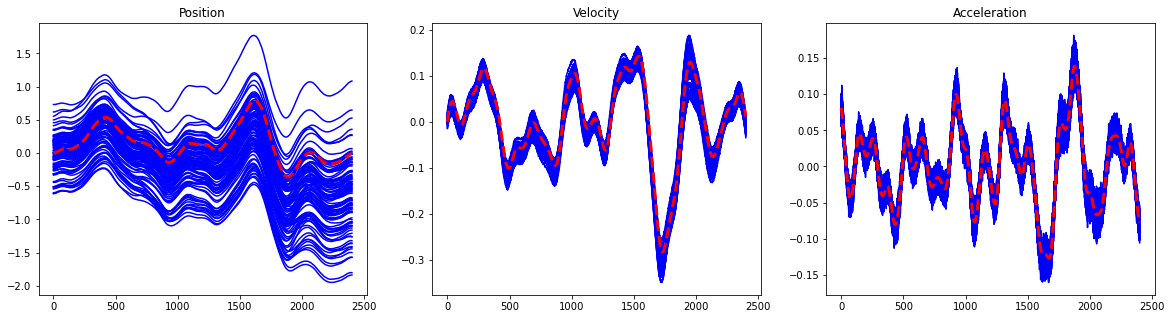

In [19]:
# plot of state space trajectories
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))

for i in range(Nprand):
    for x in xb_ffbs_rand_list[i][Nmcmc//2:]: # remove first half as burnin
        ax1.plot(x[:,0], '-b')
        ax2.plot(x[:,1], '-b')
        ax3.plot(x[:,2], '-b')

ax1.plot(xsolve2[:,0],'--r', linewidth=3)
ax2.plot(xsolve2[:,1],'--r', linewidth=3)
ax3.plot(xsolve2[:,2],'--r', linewidth=3)

ax1.set_title('Position')
ax2.set_title('Velocity')
ax3.set_title('Acceleration')

plt.show()

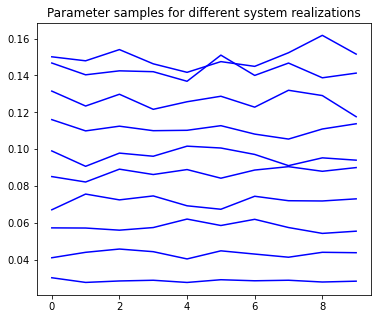

In [20]:
# plot of parameter realizations
plt.figure(figsize=(6,5))
for i in range(Nprand):
    plt.plot(np.array(para_ffbs_rand_list[i])[Nmcmc//2:], '-b') # remove first half as burnin

plt.title('Parameter samples for different system realizations')    
plt.show()

### Fullblown uncertainty quantification - including variability in the forcing

Simulation hierarchy: $ F \rightarrow (m,k,c) \rightarrow (x_{0:T}, \theta) $

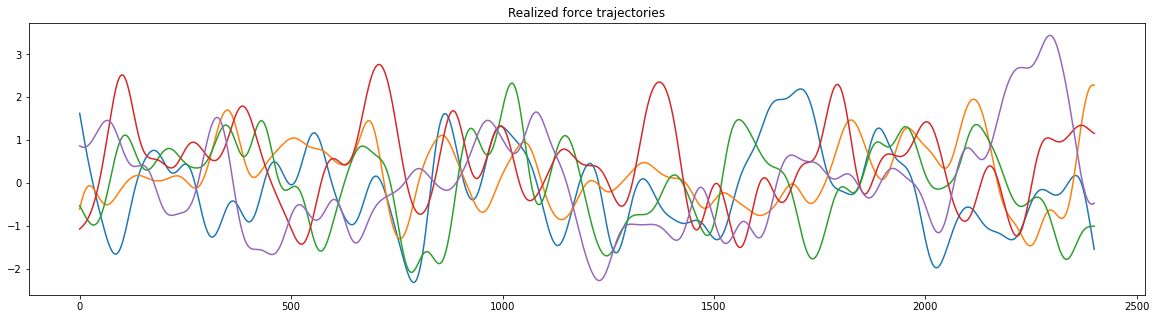

In [21]:
# simulate loads
Nfrand = 5
Frand = myForceSim(tvec=time.reshape(-1,1), sig_f=1, l_f=1, Nsim=Nfrand) # function has latent seed=1

plt.figure(figsize=(20,5))
for x in (Frand.T):
    plt.plot(x)
plt.title('Realized force trajectories')
plt.show()

In [22]:
# simulate realizations of system
np.random.seed(3)
xrandSysAndF_list = []
for i in range(Nfrand):
    xrandSys_list_i = myStateGenerator(x_init, dt, N, Frand[:,i], Nprand)
    xrandSys_mat_i = np.array(xrandSys_list_i)
    xrandSysAndF_list.append( xrandSys_mat_i )
    
xrandSysAndF_mat = np.array(xrandSysAndF_list)

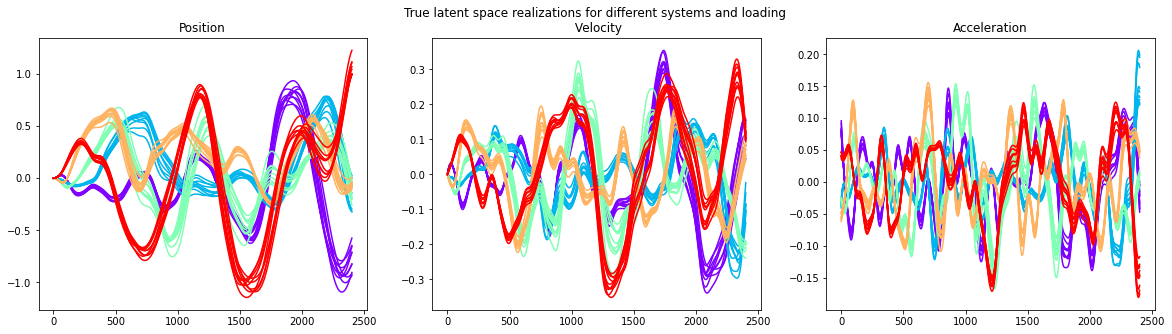

In [23]:
# plot of state space trajectories
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
color = cm.rainbow(np.linspace(0, 1, Nfrand))
for i, c in zip(range(Nfrand), color):
    for j in range(Nprand):
        ax1.plot(xrandSysAndF_list[i][j,:,0], c=c)
        ax2.plot(xrandSysAndF_list[i][j,:,1], c=c)
        ax3.plot(xrandSysAndF_list[i][j,:,2], c=c)

ax1.set_title('Position')
ax2.set_title('True latent space realizations for different systems and loading \n Velocity')
ax3.set_title('Acceleration')

plt.show()

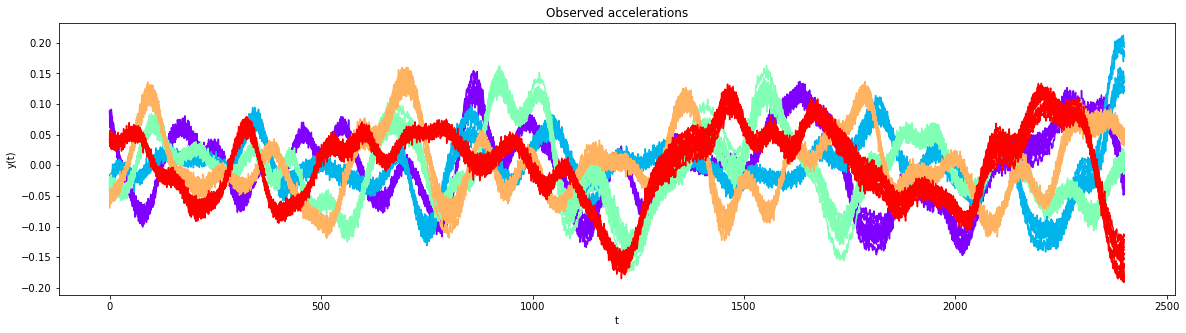

In [24]:
# realized accelerations signals (incl. noise)
np.random.seed(5)
y2randpf = xrandSysAndF_mat[:,:,:,2] + np.random.normal(size=(Nfrand,Nprand,N+1)) * sig_noise2

plt.figure(figsize=(20,5))
color = cm.rainbow(np.linspace(0, 1, Nfrand))
for i, c in zip(range(Nfrand), color):
    for j in range(Nprand):
        plt.plot(y2randpf[i,j,:], c=c)
        
plt.title('Observed accelerations')
plt.xlabel('t')
plt.ylabel('y(t)')
plt.show()

In [25]:
# %%time
# np.random.seed(7)
# xb_ffbs_randpf_list = []
# para_ffbs_randpf_list = []

# for i in range(Nfrand):
#     xb_ffbs_randpf_list_i = []
#     para_ffbs_randpf_list_i = []
#     for j in range(Nprand):
#         xb_ffbs_base_ij, para_ffbs_base_ij = dlmt.myPosSamplerQbase(y=y2randpf[i,j,:].reshape(-1,1), 
#                                                                     cQ=cQinit, cR=np.array([sig_noise2]).reshape(-1,1), 
#                                                                     mu0 = mu02, Sigma0 = Sigma02, 
#                                                                     A = A, Phi = Phi,  
#                                                                     Qbase = Qbase_b, Nsamp=Nmcmc)
#         xb_ffbs_randpf_list_i.append(xb_ffbs_base_ij); para_ffbs_randpf_list_i.append(para_ffbs_base_ij)

#     xb_ffbs_randpf_list.append(xb_ffbs_randpf_list_i); para_ffbs_randpf_list.append(para_ffbs_randpf_list_i)

In [26]:
%%time

def MCMCsampling_prand(yrandp):
    xb_para_ffbs_randp = []
    for j in range(Nprand):
        xb_para_ffbs_base_j = dlmt.myPosSamplerQbase(y=yrandp[j,:].reshape(-1,1), 
                                                     cQ=cQinit, cR=np.array([sig_noise2]).reshape(-1,1), 
                                                     mu0 = mu02, Sigma0 = Sigma02, 
                                                     A = A, Phi = Phi,  
                                                     Qbase = Qbase_b, Nsamp=Nmcmc)
        xb_para_ffbs_randp.append(xb_para_ffbs_base_j)
        
    return(xb_para_ffbs_randp)

np.random.seed(7)
xb_para_ffbs_randpf_list = joblib.Parallel(n_jobs=-2)(joblib.delayed(MCMCsampling_prand)(x) for x in y2randpf)

Wall time: 1min 21s


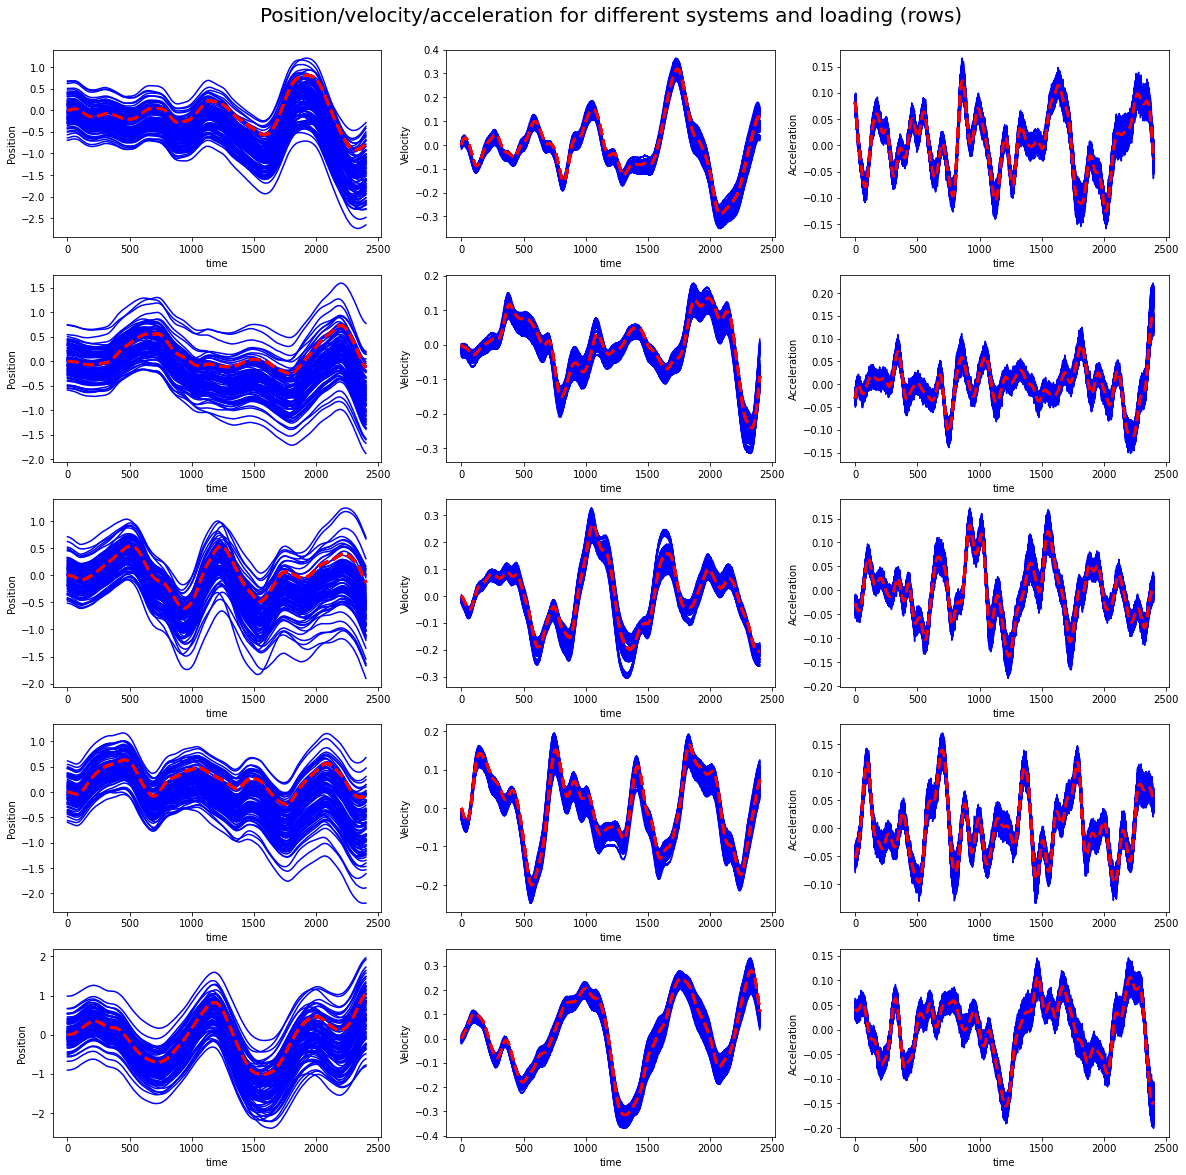

In [27]:
# plot of state space trajectories
fig, ax = plt.subplots(Nfrand, 3, figsize=(20,20))

for i in range(Nfrand):
    for j in range(Nprand):
        for x in xb_para_ffbs_randpf_list[i][j][0][Nmcmc//2:]: # remove first half as burnin
            ax[i,0].plot(x[:,0], '-b')
            ax[i,1].plot(x[:,1], '-b')
            ax[i,2].plot(x[:,2], '-b')

        ax[i,0].plot(np.mean(xrandSysAndF_list[i][:,:,0],axis=0),'--r', linewidth=3)
        ax[i,1].plot(np.mean(xrandSysAndF_list[i][:,:,1],axis=0),'--r', linewidth=3)
        ax[i,2].plot(np.mean(xrandSysAndF_list[i][:,:,2],axis=0),'--r', linewidth=3)
        
        for k in range(3):
            ax[i,k].set_xlabel('time')
 
        ax[i,0].set_ylabel('Position') 
        ax[i,1].set_ylabel('Velocity')
        ax[i,2].set_ylabel('Acceleration') 
        
ax[0,1].set_title('Position/velocity/acceleration for different systems and loading (rows)\n', fontsize=20)
plt.show()

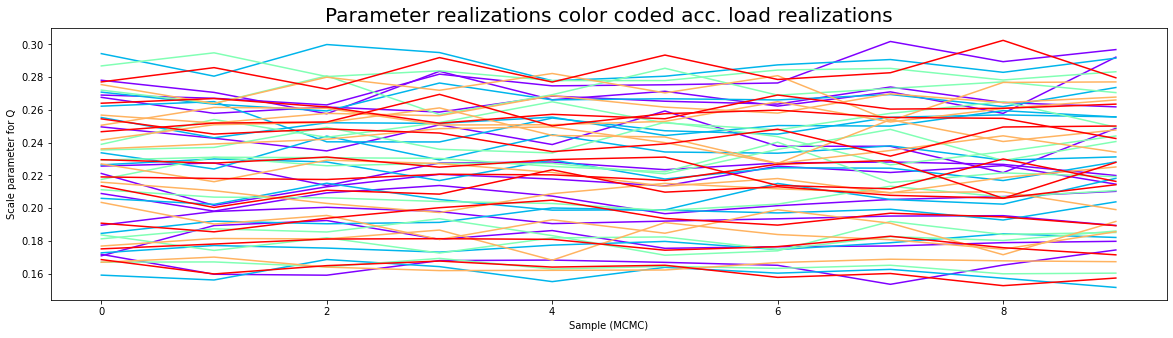

In [28]:
# plot of state space trajectories
plt.figure(figsize=(20,5))
color = cm.rainbow(np.linspace(0, 1, Nfrand))
for i, c in zip(range(Nfrand), color):
    for j in range(Nprand):
        plt.plot(xb_para_ffbs_randpf_list[i][j][1][Nmcmc//2:], c=c)

plt.ylabel('Scale parameter for Q')
plt.xlabel('Sample (MCMC)')
plt.title('Parameter realizations color coded acc. load realizations', fontsize=20)
plt.show()

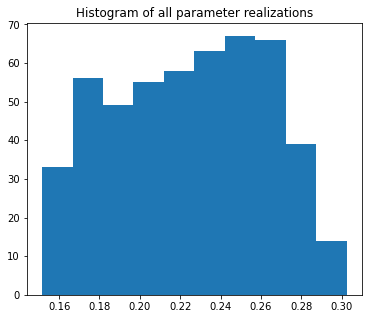

In [29]:
plt.figure(figsize=(6,5))
plt.hist(np.array(xb_para_ffbs_randpf_list, dtype=object)[:,:,1,Nmcmc//2:].flatten())
plt.title('Histogram of all parameter realizations')
plt.show()